### **Data Description**

**Imports**

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

**Load raw dataset**

In [3]:
dataset = pd.read_csv('broward_data.csv')   # raw dataset (dont edit this dataframe)
cleaned_data = dataset.copy()                      # separate dataframe to hold cleaned data

### IDENTIFY FEATURES AND TARGETS ###
features = ['person_id','screening_date','sex','race','age_at_current_charge',
            'age_at_first_charge','p_charges','p_incarceration','p_probation',
            'p_juv_fel_count','p_felprop_viol','p_murder','p_felassault',
            'p_misdeassault','p_famviol','p_sex_offense','p_weapon','p_fta_two_year',
            'p_fta_two_year_plus','current_violence','current_violence20',
            'p_pending_charge','p_felony','p_misdemeanor','p_violence',
            'total_convictions','p_arrest','p_property','p_traffic','p_drug','p_dui',
            'p_domestic','p_stalking','p_voyeurism','p_fraud','p_stealing','p_trespass',
            'six_month','one_year','three_year','five_year']
targets = ['general_two_year','general_six_month','drug_two_year','property_two_year',
           'misdemeanor_two_year','felony_two_year','violent_two_year','drug_six_month', 
           'property_six_month','misdemeanor_six_month','felony_six_month',
           'violent_six_month']


# make everything an integer
# dataset.dtypes

# id isnt helpful
cleaned_data = cleaned_data.drop('person_id', axis=1)
features.remove('person_id')

# in cleaned data, make screening date an integer
dataset['screening_date'] = pd.to_datetime(dataset['screening_date'])
first_date = dataset['screening_date'].min()
cleaned_data = cleaned_data.drop('screening_date', axis=1)
cleaned_data['screening_date'] = (dataset['screening_date'] - first_date).dt.days

# find out what races are represented, and make each race its own one-hot encoded feature
races = dataset['race'].unique()
cleaned_data = pd.get_dummies(cleaned_data, columns=['race'], prefix='', prefix_sep='') *1
cleaned_data.columns = [col.replace(' ', '_').replace('-', '_') for col in cleaned_data.columns]
# add new race variables to features
for column in cleaned_data.columns:
    if column not in features and column not in targets:
        features.append(column)
features.remove('race')



**Check data for any glaring issues**

In [4]:
### MISSING DATA ###
# is any data missing? 
missing_vals = dataset.isna().sum().sum()           #num missing values
total_vals = np.product(dataset.shape)              #total num values
pct_missing = (missing_vals / total_vals) * 100     #percent of the data missing
#print(f'Percentage of the data missing: {pct_missing}%\n')

### DUPLICATES ###
#if any person is in the dataset twice, the duplicate will be removed
dataset.drop_duplicates(subset=[dataset.columns[0]], inplace=True)

### INCORRECT DATA TYPES ###
#make sure these look correct
data_types = dataset.dtypes
#print(data_types)

#### **Preliminary Analysis**

##### Histograms

['screening_date', 'sex', 'age_at_current_charge', 'age_at_first_charge', 'p_charges', 'p_incarceration', 'p_probation', 'p_juv_fel_count', 'p_felprop_viol', 'p_murder', 'p_felassault', 'p_misdeassault', 'p_famviol', 'p_sex_offense', 'p_weapon', 'p_fta_two_year', 'p_fta_two_year_plus', 'current_violence', 'current_violence20', 'p_pending_charge', 'p_felony', 'p_misdemeanor', 'p_violence', 'total_convictions', 'p_arrest', 'p_property', 'p_traffic', 'p_drug', 'p_dui', 'p_domestic', 'p_stalking', 'p_voyeurism', 'p_fraud', 'p_stealing', 'p_trespass', 'six_month', 'one_year', 'three_year', 'five_year', 'African_American', 'Asian', 'Caucasian', 'Hispanic', 'Native_American', 'Other']


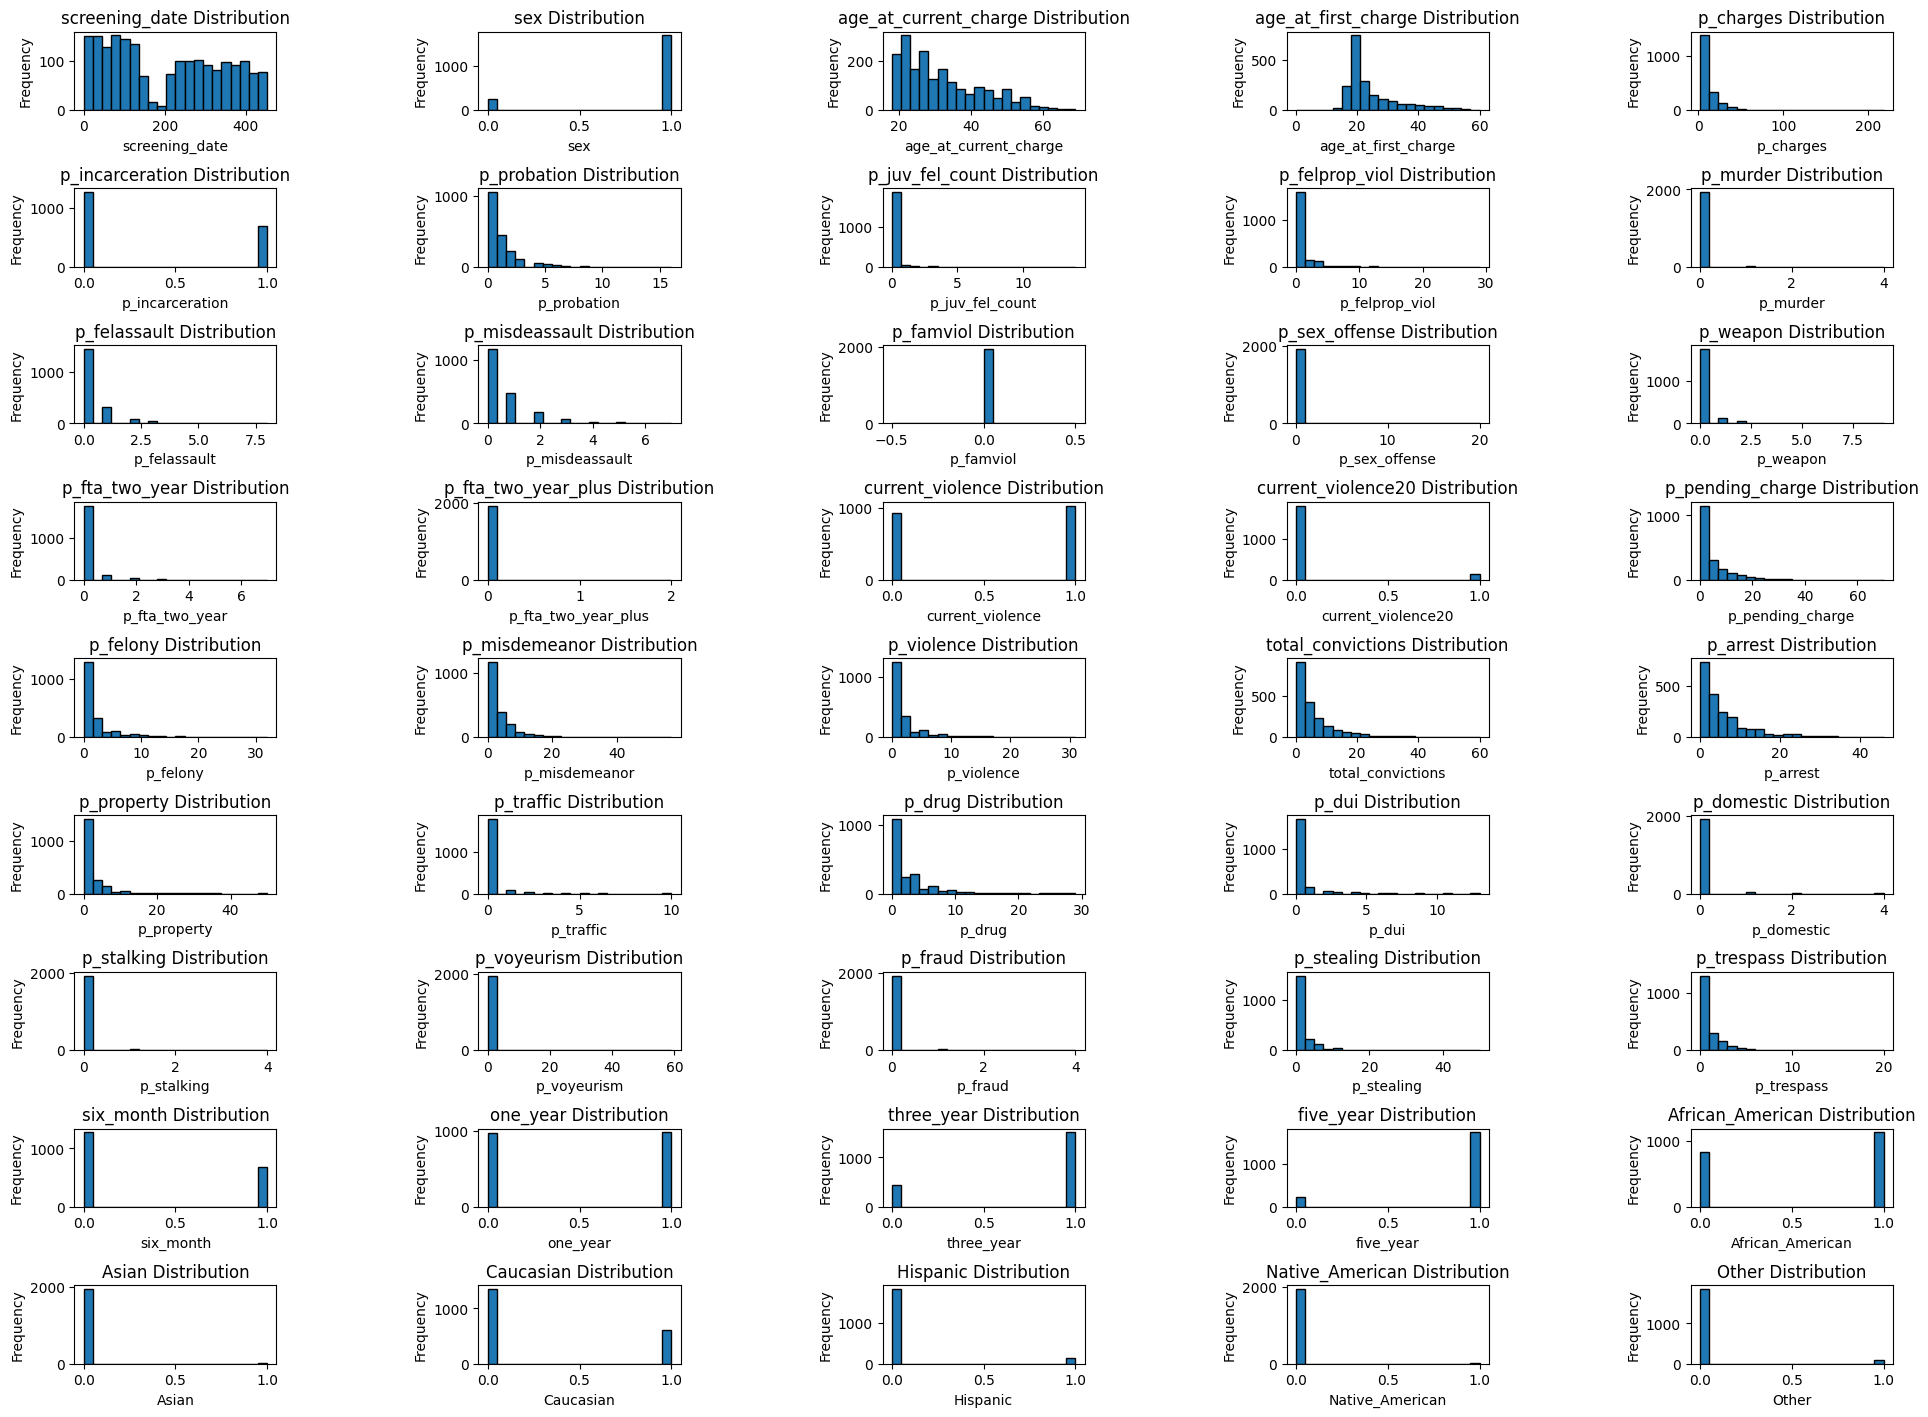

['screening_date', 'sex', 'age_at_current_charge', 'age_at_first_charge', 'p_charges', 'p_incarceration', 'p_probation', 'p_juv_fel_count', 'p_felprop_viol', 'p_murder', 'p_felassault', 'p_misdeassault', 'p_famviol', 'p_sex_offense', 'p_weapon', 'p_fta_two_year', 'p_fta_two_year_plus', 'current_violence', 'current_violence20', 'p_pending_charge', 'p_felony', 'p_misdemeanor', 'p_violence', 'total_convictions', 'p_arrest', 'p_property', 'p_traffic', 'p_drug', 'p_dui', 'p_domestic', 'p_stalking', 'p_voyeurism', 'p_fraud', 'p_stealing', 'p_trespass', 'six_month', 'one_year', 'three_year', 'five_year', 'African_American', 'Asian', 'Caucasian', 'Hispanic', 'Native_American', 'Other']


In [5]:
### HISTOGRAMS ###
# to show distribution of data
# display details
cols=5
rows = (len(features)+cols-1)//cols
fig, axes = plt.subplots(rows, cols, figsize=(20, 15))
fig.tight_layout(pad=5.0)
print(features)
# loop through features
for i, feature in enumerate(features):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    ax.hist(cleaned_data[feature], bins=20, edgecolor='black')
    ax.set_title(f"{feature} Distribution")
    ax.set_xlabel(feature)
    ax.set_ylabel("Frequency")

for n in range(i+1, rows*cols):
    fig.delaxes(axes.flatten()[n])

# display
plt.subplots_adjust(hspace=1, wspace=1)
plt.show()
print(features)



In [6]:
# it appears that the variance of feature 'p_famviol' is zero. confirm this:
if dataset['p_famviol'].max() == dataset['p_famviol'].min():
    print("yeah they're all the same")
else: 
    print("nah")


yeah they're all the same


In [7]:
# remove useless feature famviol
cleaned_data = cleaned_data.drop('p_famviol', axis=1)
features.remove('p_famviol')

In [8]:
# it also looks like theres one person who was first charged at age 0:

if((dataset['age_at_first_charge'] == 0).any()):
    print("huh thats weird")
else:
    print("nah")

# how many are there?
count = (dataset['age_at_first_charge'] == 0).sum()
print(f'How many: {count}')


huh thats weird
How many: 1


In [9]:
# remove weird datapoint where that guy was charged at age 0
cleaned_data = cleaned_data[cleaned_data['age_at_first_charge'] != 0]

##### Scatter plots

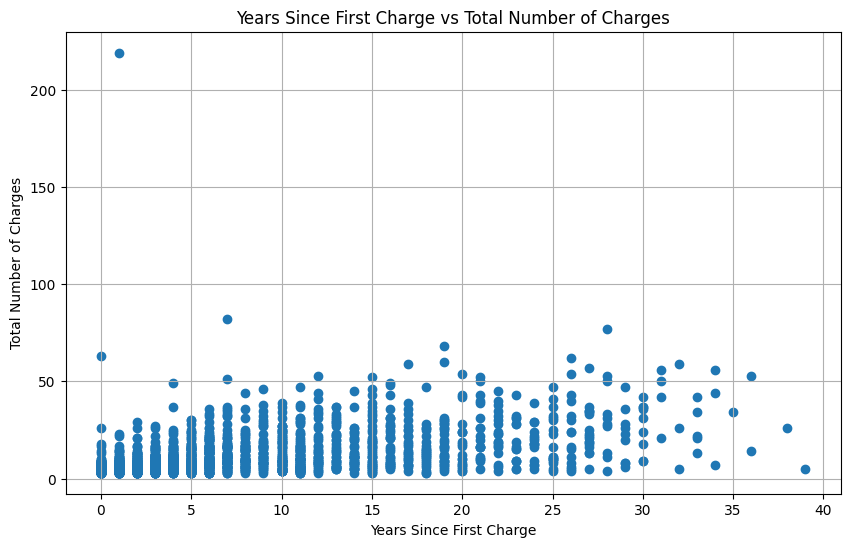

In [10]:
### SCATTER PLOTS ###
# to show relationships between features/targets

# years since first charge vs number of past charges
total_charges = dataset['p_charges'] + 1
years_elapsed = dataset['age_at_current_charge'] - dataset['age_at_first_charge']



plt.figure(figsize=(10, 6))
plt.scatter(years_elapsed, total_charges)
plt.title('Years Since First Charge vs Total Number of Charges')
plt.xlabel('Years Since First Charge')
plt.ylabel('Total Number of Charges')
plt.grid(True)
plt.show()

In [11]:
# get rid of that crazy guy getting like 200+ charges in a year
cleaned_data = cleaned_data[cleaned_data['p_charges'] < 200]

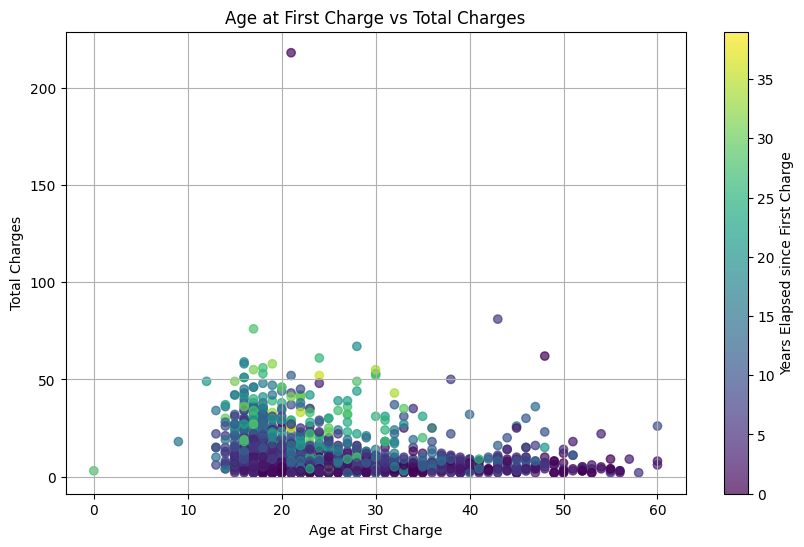

In [12]:
# age at first charge vs total charges
plt.figure(figsize=(10, 6))
scatter = plt.scatter(dataset['age_at_first_charge'], dataset['p_charges'], c=[years_elapsed], alpha=0.7)
plt.title('Age at First Charge vs Total Charges')
plt.xlabel('Age at First Charge')
plt.ylabel('Total Charges')
plt.grid(True)
cbar = plt.colorbar(scatter, label='Years Elapsed since First Charge')
plt.show()


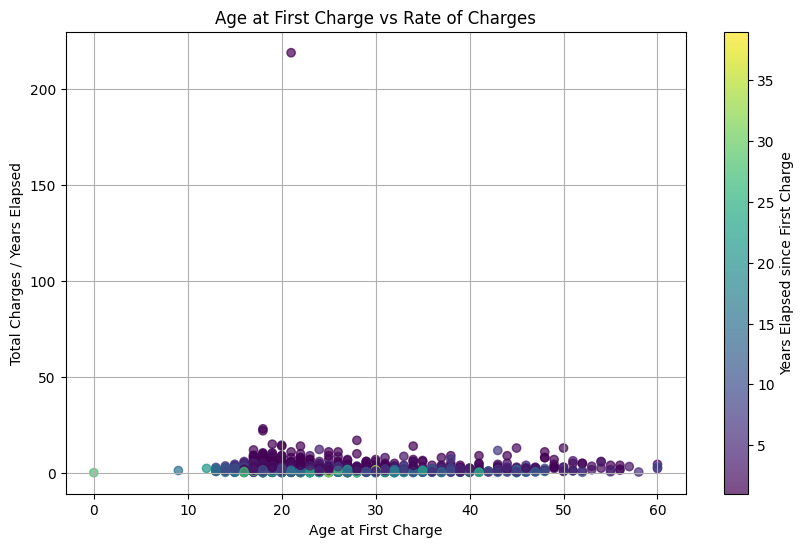

In [13]:
# age at first charge vs rate of charges
plt.figure(figsize=(10, 6))
scatter = plt.scatter(dataset['age_at_first_charge'], total_charges/years_elapsed, c=years_elapsed, alpha=0.7)
plt.title('Age at First Charge vs Rate of Charges')
plt.xlabel('Age at First Charge')
plt.ylabel('Total Charges / Years Elapsed')
plt.grid(True)
cbar = plt.colorbar(scatter, label='Years Elapsed since First Charge')
plt.show()

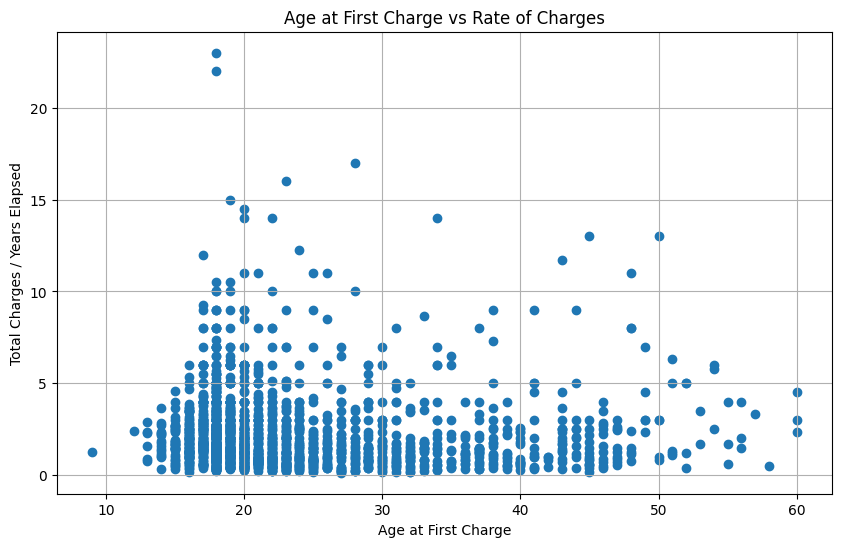

In [14]:
#yeah def get rid of that guy, what's it look like without him? 

years_elapsed = cleaned_data['age_at_current_charge'] - cleaned_data['age_at_first_charge']
total_charges = cleaned_data['p_charges'] + 1
plt.figure(figsize=(10, 6))
scatter = plt.scatter(cleaned_data['age_at_first_charge'], total_charges/years_elapsed)
plt.title('Age at First Charge vs Rate of Charges')
plt.xlabel('Age at First Charge')
plt.ylabel('Total Charges / Years Elapsed')
plt.grid(True)
plt.show()

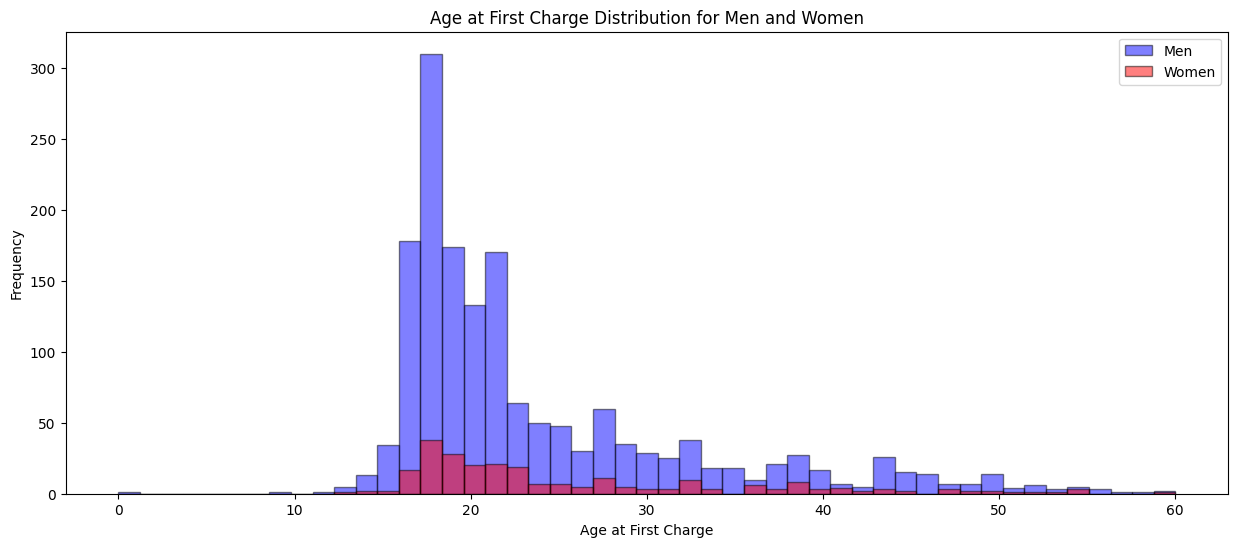

In [15]:
# compare men and women age first charge distribution 
men = dataset[dataset['sex'] == 1]
women = dataset[dataset['sex'] == 0]
bins = np.linspace(min(dataset['age_at_first_charge']), max(dataset['age_at_first_charge']), 50)

plt.figure(figsize=(15, 6))
plt.hist(men['age_at_first_charge'], bins=bins, edgecolor='black', color='blue', alpha=0.5, label='Men')
plt.hist(women['age_at_first_charge'], bins=bins, edgecolor='black', color='red', alpha=0.5, label='Women')
plt.title('Age at First Charge Distribution for Men and Women')
plt.xlabel('Age at First Charge')
plt.ylabel('Frequency')
plt.legend()
plt.show()

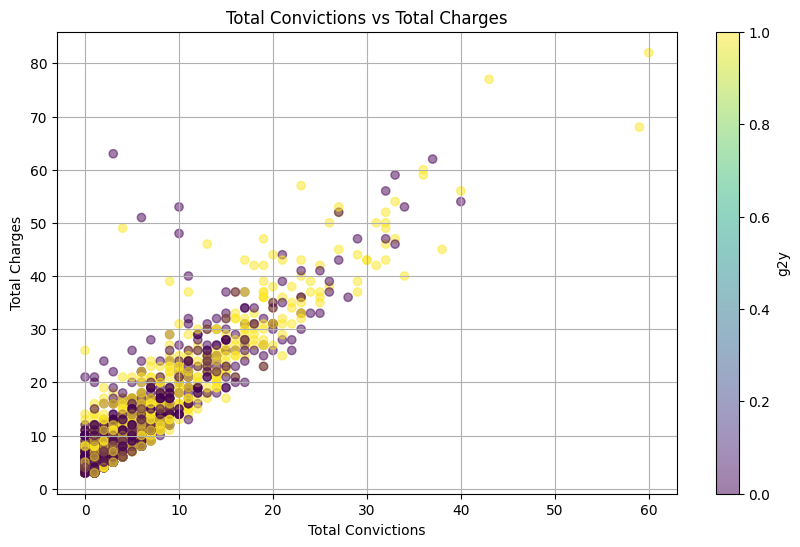

In [16]:
# total convictions vs total charges
plt.figure(figsize=(10, 6))
scatter = plt.scatter(cleaned_data['total_convictions'], cleaned_data['p_charges']+1, c=cleaned_data['general_two_year'], alpha=0.5)
plt.title('Total Convictions vs Total Charges')
plt.xlabel('Total Convictions')
plt.ylabel('Total Charges')

cbar = plt.colorbar(scatter, label='g2y')
plt.grid(True)
plt.show()

**Split into test and training**

In [17]:
X = cleaned_data[features]   # feature values for all rows in cleaned dataset
y = cleaned_data[targets]    # target values for all rows in cleaned dataset

### SPLIT INTO TRAIN AND TEST SETS ###
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**Standardize**

In [22]:
#scale training set, then use the same variables to scale the test set
scaler = StandardScaler()
train_std = scaler.fit_transform(X_train)
test_std = scaler.transform(X_test)

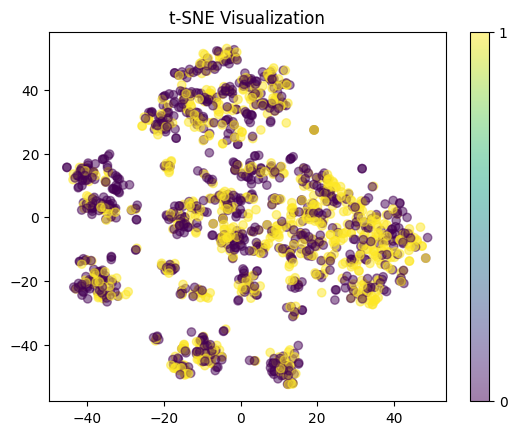

In [19]:
### DIMENSIONALITY REDUCTION ###
#tsne
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import TSNE
X = train_std
y = y_train['general_two_year']



tsne = TSNE(n_components=2, perplexity=30, random_state=0)
X_tsne = tsne.fit_transform(X)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, alpha=0.5)
plt.colorbar(ticks=range(10))
plt.title('t-SNE Visualization')
plt.show()


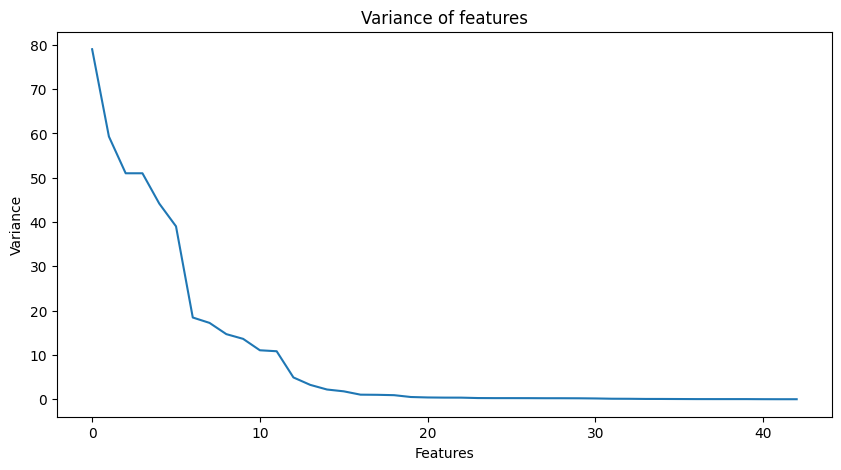

In [20]:
#variance threshold
from sklearn.feature_selection import VarianceThreshold

X_var = VarianceThreshold().fit_transform(cleaned_data[[feature for feature in features if feature != 'screening_date']])

# Calculate the variance of each feature
variances = VarianceThreshold().fit(cleaned_data[[feature for feature in features if feature != 'screening_date']]).variances_

# Plot the variance
plt.figure(figsize=(10, 5))
plt.plot(sorted(variances, reverse=True))
plt.title('Variance of features')
plt.xlabel('Features')
plt.ylabel('Variance')
plt.show()



In [23]:


### CLUSTERING ALGORITHMS ###

### ROC CURVES ###

### .CSV FILES FOR TRAINING AND TESTING ###
train_std = pd.DataFrame(train_std, columns=features)
test_std = pd.DataFrame(test_std, columns=features)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)


train_data = pd.concat([train_std, y_train], axis=1)
test_data = pd.concat([test_std, y_test], axis=1)
train_data.to_csv('standardized_training.csv', index=False)
test_data.to_csv('standardized_testing.csv', index=False)